# Урок 5. Случайный лес

**Дерево решений**

1) Построение дерева    

    Для каждого узла: 
    - выбираем наилучшее разбиение (проверяем все признаки и все уникальные значения каждого признака) с максимальным приростом информации
    - разбиваем данные на два подмножества
    Для каждого листа:
    - считаем среднее значение ЦП / долю объектов каждого класса / преобладающий класс
2) Предсказание
    - новый объект проходит через все узлы и попадает в лист
    - выдаем прогноз, соответствующий расчетам в листе
            
        

Данный урок будет своеобразным логическим продолжением предыдущего. Основным недостатком деревьев решений является их склонность к переобучению и тот факт, что даже при небольшом изменении обучающей выборки дерево может значительно измениться. Однако их объединение в _ансамбли_ или _композиции_ на практике дает очень хорошие результаты. Ансамбли - это методы, сочетающие в себе несколько алгоритмов машинного обучения для получения более мощной модели. 

В случае задачи регрессии при использовании композиции $a(x)$ из $N$ _базовых алгоритмов_ $b_{n}(x)$ ответом будет считаться среднее значение ответа каждого алгоритма

$$a(x) = \frac{1}{N}\sum_{n=1}^{N}b_{n}(x),$$

в задачах классификации, соответственно, знак полученного усредненного ответа или (что аналогично) класс определяется путем _голосования_: объект относится к классу, за который "проголосовало" наибольшее число базовых алгоритмов.

Одни из самых хорошо зарекомендовавших себя на практике решения задач классификации и регрессии с использованием деревьев решения - это _бэггинг (случайный лес)_ и _градиентный бустинг_. В этом уроке пойдет речь о первом методе.

Случайные леса названы так из-за того, что в процесс построения деревьев, из которых они состоят, внесен элемент случайности для обеспечения уникальности каждого из деревьев. Такая рандомизация заключается в обучении базовых алгоритмов на разных подвыборках обучающей выборки. Один из способов построения случайных подвыборок - _бутстрап (bootstrap)_. Этот метод заключается в получении из выборки длины $l$ нескольких разных выборок той же длины $l$. Для получения бутстрап-выборки из исходной выборки $l$ раз выбирается случайный элемент, причем каждый раз новый элемент выбирается из всей выборки. Таким образом, в полученной в конечном итоге бутстрап-выборке некоторые элементы исходной выборки будут встречаться несколько раз, а некоторые (примерно 37% выборки) будут вовсе отсутствовать, и при повторении $N$ раз мы получим $N$ разных выборок длиной $l$. Например, если у нас есть исходная выборка вида [a, b, c, d, e], возможными бутстрап-выборками могут быть [a, b, a, c, b] или [b, e, e, d, b] и т.д.

In [4]:
# Bagging = Bootstrap aggregating
X = [1, 2, 3, 4, 5]

X1 = [2, 4, 2, 4, 1] # tree_1.fit(X1, y)
X2 = [1, 3, 2, 3, 2] # tree_2.fit(X2, y)
X3 = [2, 4, 5, 5, 5] # tree_3.fit(X3, y)

tree_1.predict(6, 7, 8, 9) # 1, 0, 0, 0
tree_2.predict(6, 7, 8, 9) # 1, 1, 1, 0
tree_3.predict(6, 7, 8, 9) # 0, 1, 0, 0
# 1, 1, 0, 0
# OOB
tree_1.predict(3, 5) # 1, 0
tree_2.predict(4, 5) # 1, 0
tree_3.predict(1, 3) # 1, 0
# 1 - 1, 2 - None, 3 - 1, 4 - 1, 5 - 0 

NameError: name 'tree_1' is not defined

Известно, что ошибка алгоритмов складывается из _смещения (bias)_ (отклонение среднего ответа обученного алгоритма от ответа идеального алгоритма) и _разброса_ или _дисперсии (variance)_ (разброс ответов обученных алгоритмов отнисительно среднего ответа) (см. дополнительные материалы). Также к этому разложению обычно прибавляется _шум_, который характеризует ошибку идеального алгоритма и которым никак нельзя управлять - это характеристика входных данных. Как правило, простые семейства алгоритмов (например, линейные классификаторы) характеризуются высоким смещением и низким разбросом, а сложные семейства (в т.ч. деревья) наоборот - низким смещением и высоким разбросом. Можно сказать, что разброс характеризует чувствительность метода обучения к выборке, то есть насколько будет изменяться ответ обученного алгоритма в зависимости от изменений в обучающей выборке.

Объединение нескольких деревьев с одинаковым смещением в композицию не будет приводить к увеличению ее смещения, а вот компонента разброса будет снижаться, если базовые алгоритмы независимы, то есть не коррелируют друг с другом: разброс композиции при усреднении ответов будет в $N$ раз меньше разброса одного базового алгоритма. Однако, на практике базовые алгоритмы всегда в той или иной степени скоррелированы, так как обучаются на подвыборках одной выборки, поэтому возникает необходимость уменьшения корреляции получаемых алгоритмов.

Есть два подхода, позволяющих уменьшить корреляцию: _бэггинг_ (обучение базовых алгоритмов на случайной подвыборке) и _метод случайных подпространств_ (обучение базовых алгоритмов на случайном подмножестве признаков) или их комбинация. В этом случае возникают гиперпараметры (параметры, которые нельзя найти или оценить по обучающей выборки, обучив алгоритм единожды) - размер подвыборки или подмножества признаков. Чем меньше брать обучающую подвыборку при бэггинге, тем меньше будет корреляция между алгоритмами, но тем больше вероятность переобучения деревьев, составляющих ансамбль.

## Алгоритм построения случайного леса

При построении случайного леса вначале генерируется количество бутстрап-выборок, равное количеству деревьев в алгоритме. Для уменьшения корреляции базовых алгоритмов рандомизируют сам процесс построения каждого дерева: если в стандартном методе построения деревьев мы в каждом узле выбираем $j$-й признак и порог $t$, с которым сравнивается его значение, и потом эти значения оптимизируются с помощью функции ошибки, то в методе случайного леса в каждой вершине $j$-й признак выбирается не из всего пространства признаков, а из его случайного подмножества размера $m$, __которое каждый раз выбирается заново__ (в этом отличие от метода случайных подпространств, где подпространство выбирается единожды и используется для построения всего дерева). 

Есть некоторые практические рекомендации по построению случайных лесов: в задачах классификации рекомендуется брать $m = \sqrt{d}$, где $d$ - общее число признаков, и строить дерево до тех пор, пока в каждом листе не останется по одному объекту, а в задаче регрессии принимать $m = d/3$ и строить дерево, пока в листьях не останется по пять объектов.

Далее построенные деревья объединяются в композицию, и при предсказаниях с его помощью используется усредненный ответ на каждом дереве.

### Out-of-Bag

Вспомним, что каждое дерево $b_{n}$, составляющее случайный лес, строится на основе бутстрапированной выборки $X_{n}$. При этом примерно 37% объектов [(вывод)](#oob) не попадают в эту выборку, и дерево на них не обучается. Эти объекты можно использовать для оценки качества полученного алгоритма, это и называется _out-of-bag error_. Для каждог объекта $x_{i}$ мы можем найти деревья, которые на нем не обучались, и вычислить ошибку: она рассчитывается как сумма значений ошибки для среднего ответа на каждом объекте $x_{i}$ среди деревьев, которые на нем не обучались:

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

Здесь $L(y, z)$ - функция потерь, а выражение в скобках и представляет из себя среднюю ошибку на объекте $x_{i}$ среди деревьев, которые на нем не обучались.

При использовании этого метода оценивания качества исчезает необходимость использовать отложенные выборки и кросс-валидацию при обучении случайных лесов.

## Реализация случайного леса

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

In [5]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [6]:
# сгенерируем данные, представляющие собой 1000 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features=5, n_informative=5, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=2, flip_y=0.1,
                                                      random_state=23)

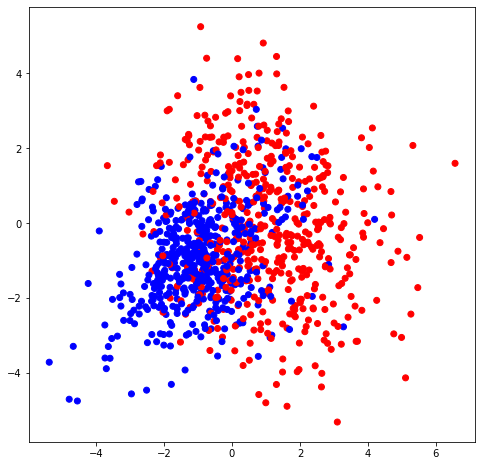

In [7]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [8]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [9]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [10]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [11]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [12]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [13]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [14]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [15]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [16]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [17]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [18]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): 
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [19]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [20]:
predictions = [[1,1,1], [1,0,0], [1,0,1], [0,0,1]]
print(*predictions)
#p = np.array(predictions).T
p = list(zip(*predictions))
print(p)
[max(set(x), key=x.count) for x in p]

[1, 1, 1] [1, 0, 0] [1, 0, 1] [0, 0, 1]
[(1, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 1)]


[1, 0, 1]

In [21]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [22]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [23]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [24]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [25]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [26]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [27]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 93.429


In [28]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 81.000


Построим лес из трех деревьев

In [29]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [30]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [31]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [32]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 97.857


In [33]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 84.667


Построим лес из десяти деревьев

In [34]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [35]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [36]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [37]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.857


In [38]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 86.333


Построим лес из пятидесяти деревьев

In [39]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [40]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [41]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [42]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [43]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 88.000


Как можно увидеть из показателей качества предсказаний, точность случайного леса возрастает при увеличении числа деревьев в нем. При этом по точности на тестовой выборке можно сказать, что при увеличении количества деревьев до 50 наш лес не переобучается. Это одна из основных особенностей случайного леса - он не переобучается при увеличении числа базовых алгоритмов, а ошибка выходит на асимптоту.

## Дополнительные материалы

1. [Смещение и разброс](https://dyakonov.org/2018/04/25/%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D0%B5-bias-%D0%B8-%D1%80%D0%B0%D0%B7%D0%B1%D1%80%D0%BE%D1%81-variance-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82/)
2. [Бэггинг с точки зрения статистики](https://habr.com/ru/company/ods/blog/324402/#begging)
3. Андреас Мюллер, Сара Гвидо, Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными (2016)

## Домашние задания

1. Задание:  
    - Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
    - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).  
    - Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).   
    - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
 


In [79]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

train_data, test_data, train_labels, test_labels = train_test_split(X, 
                                                                    y, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

Построим лес из одного дерева

In [80]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [81]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [82]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [83]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 92.429


In [84]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 75.000


Построим лес из трех деревьев

In [122]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [123]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [124]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [125]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 95.143


In [126]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 77.667


Text(0.5, 1.0, 'Test accuracy=77.67')

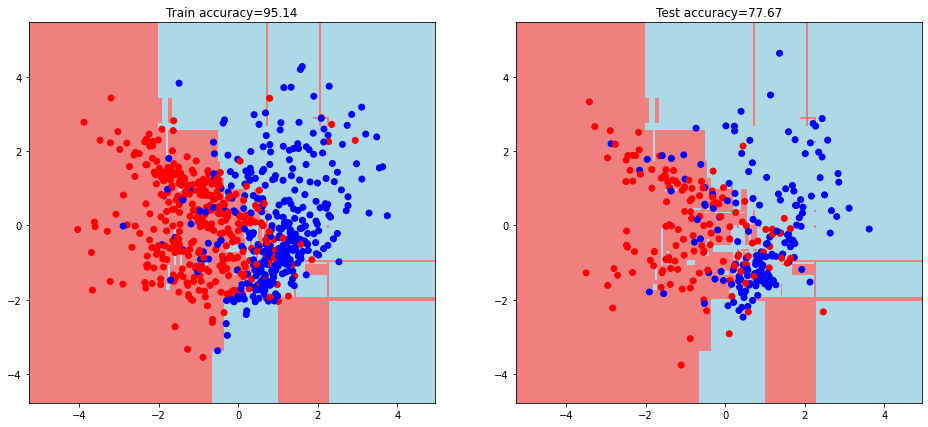

In [127]:
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из десяти деревьев

In [128]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [129]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [130]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [131]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.429


In [132]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 79.667


Text(0.5, 1.0, 'Test accuracy=79.67')

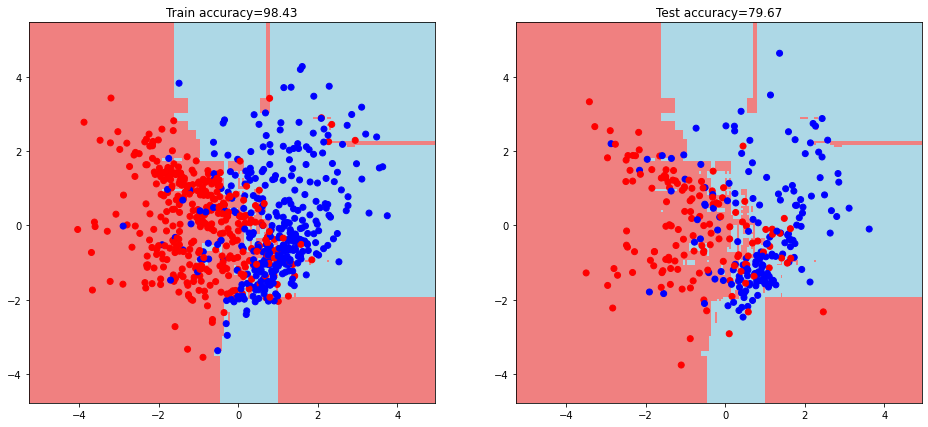

In [133]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Построим лес из пятидесяти деревьев

In [101]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [102]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [103]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [104]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [105]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 78.667


Построим лес из ста деревьев

In [106]:
n_trees = 100
my_forest_100 = random_forest(train_data, train_labels, n_trees)

In [107]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_100, train_data)

In [108]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_100, test_data)

In [109]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000


In [110]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 100 деревьев на тестовой выборке: 79.667


Построим лес из двухсот деревьев

In [111]:
n_trees = 200
my_forest_200 = random_forest(train_data, train_labels, n_trees)

In [112]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_200, train_data)

In [113]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_200, test_data)

In [114]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 200 деревьев на обучающей выборке: 100.000


In [115]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 200 деревьев на тестовой выборке: 79.333


Вывод: С увеличением количества деревьев наблюдаем ярковыраженное переобучение-т.е. начиная с 50 деревьев 100% точность на тренировочных данных при это менее 80% точность на тестовых данных. Наилучший результат по точности на тестовых данных показан алгоритмом с количеством деревьев 10. Возможно количество деревьев должно варьероваться между 5 и 10 - гипотеза требует доп. проверки

2. (\*) Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

3. (\**) Курсовой проект в этом курсе по желанию. На выбор две задачи:  
a) https://www.kaggle.com/c/tutors-expected-math-exam-results - предсказание среднего балла на ЕГЭ по математике, задача регрессии;  
b) https://www.kaggle.com/c/choose-tutors - предсказание вероятности того, что репетитор подходит студенту, задача бинарной классификации.  
При решении запрещены любые импорты, кроме следующих:

```
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
```

## Дополнительный материал

Примерно 37 % объектов остаются вне бутстрэп-выборки и не используются при построении i-го дерева. <a id='oob'>Доказательство.</a> 

Пусть в выборке $n$ объектов. Тогда вероятность того, что объект попадет в подвыборку на каждом шаге равна $1/n$. Значит вероятность того, что он НЕ попадет в подвыборку равна $(1-1/n)$. 

Размер подвыборки $n$, мы должны $n$ раз отбирать объекты с возвращением. Получаем, что вероятность для каждого объекта не быть выбранным $n$ раз равна $(1-1/n)^n$. Возьмем предел этого выражения при $n \to +\infty$:

$$\lim_{n \to +\infty}\Big(1-\frac{1}{n}\Big)^n=\frac{1}{e}\approx0.37$$

Получили, что примерно 37 % объектов не попадают в каждую бутстрэп-выборку.